In [1]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from skimage import io

In [3]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

## Loading image

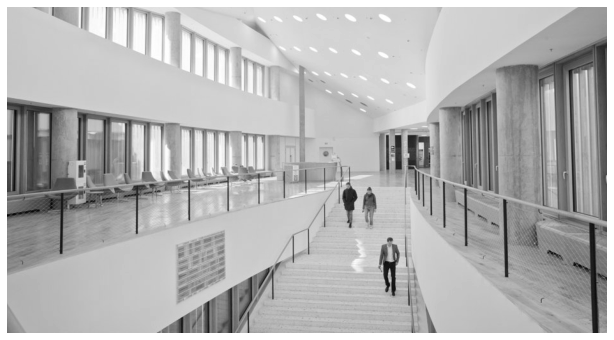

In [4]:
img_orig = np.int16(io.imread('skoltech_1.png'))
img = np.float32(cv2.imread('skoltech_1.png', 0))

plot_img(img)

## Choosing template

In [5]:
template = img[6:31,579:604]
template = img[1:36,574:609]  # more backgound = better; why? = interesting question to think about

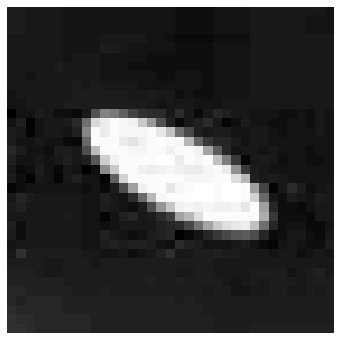

In [6]:
plot_img(template)

### Convolution from lecture 2 + normalization

In [7]:
def convolve(image, kernel, normed=False):
    assert image.ndim == kernel.ndim == 2
    
    # kernel = np.flip(kernel, axis=range(kernel.ndim))  # <- we do not need flipping in cross-corelation
    shape = np.array(image.shape) - kernel.shape + 1
    result = np.empty(shape, dtype=float)
    h, w = kernel.shape
    
    if normed:
        kernel_normed = kernel - np.mean(kernel)
        k_norm = np.sum(kernel_normed ** 2)
        
    for i, j in np.ndindex(*shape):
        if normed:
            patch = image[i:i + h, j:j + w]
            patch_normed = patch - np.mean(patch)
            result[i, j] = np.sum(patch_normed * kernel_normed) / np.sqrt(np.sum(patch_normed ** 2) * k_norm)
        else:
            result[i, j] = (image[i:i + h, j:j + w] * kernel).sum()
            
    return result

    
def convolve_same(image, kernel, normed=False):
    # pad image before convolution to obtain same resulting shape
    delta = np.array(kernel.shape) - 1
    # left and right padding
    left = delta // 2
    right = delta - left
    padding = np.array([left, right]).T

    image = np.pad(image, padding, mode='constant') 
    return convolve(image, kernel, normed=normed)

## Simple convolution

In [8]:
from skimage.feature import match_template

In [9]:
corr_conv = convolve_same(img, template)
corr_skimage = match_template(img, template, pad_input=True)

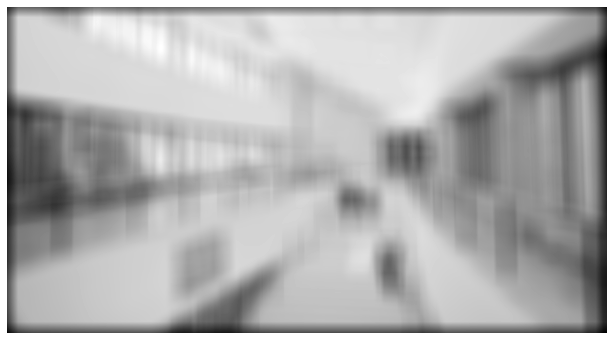

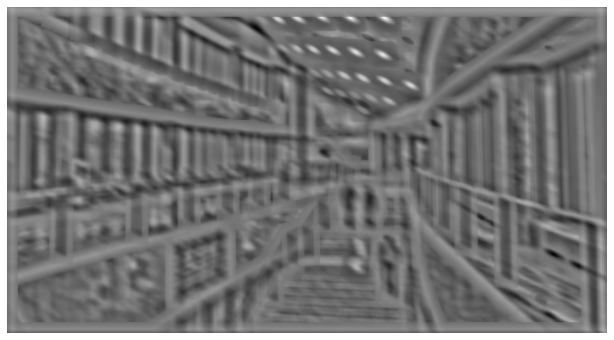

In [10]:
plot_img(corr_conv)
plot_img(corr_skimage)

## Normalized convolution

https://www.researchgate.net/publication/2378357_Fast_Normalized_Cross-Correlation

In [11]:
corr_conv = convolve_same(img, template, normed=True)
corr_skimage = match_template(img, template, pad_input=True)

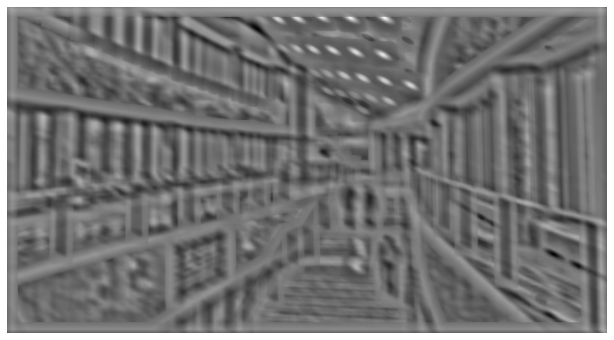

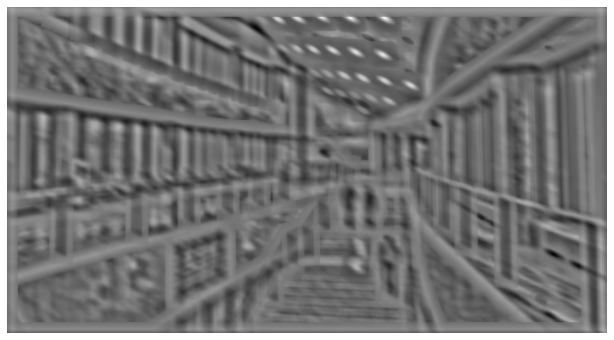

In [12]:
plot_img(corr_conv)
plot_img(corr_skimage)

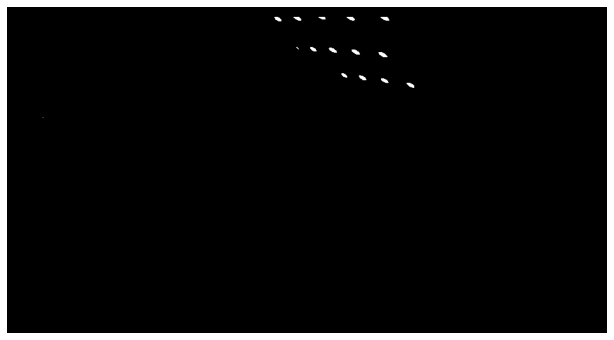

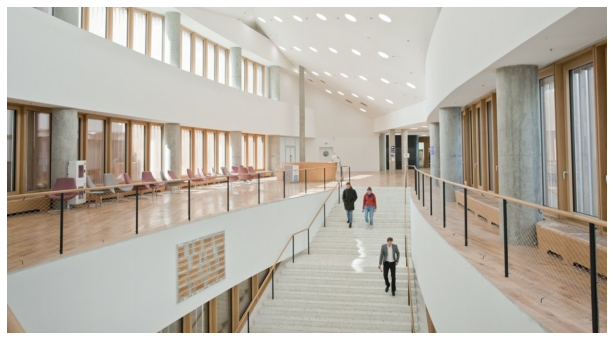

In [13]:
plot_img(corr_conv > 0.5)
plot_img(img_orig, cmap=None)

## Finding oblects: thresholding and local maximum

In [14]:
from skimage.measure import label


# maximum -> center of mass
def get_local_centers(corr, th):
    lbl, n = label(corr >= th, connectivity=2, return_num=True)
    return np.int16([np.round(np.mean(np.argwhere(lbl == i), axis=0)) for i in range(1, n + 1)])


def plot_rectangles(img, points, bbox_shape):
    points = np.int16(points)[::, ::-1]
    res_img = np.int16(img.copy())
    for pt in points:
        cv2.rectangle(res_img, (pt[0] - bbox_shape[0] // 2, pt[1] - bbox_shape[1] // 2),
                      (pt[0] + bbox_shape[0] // 2, pt[1] + bbox_shape[1] // 2), (255, 0, 0), 1)
    return res_img

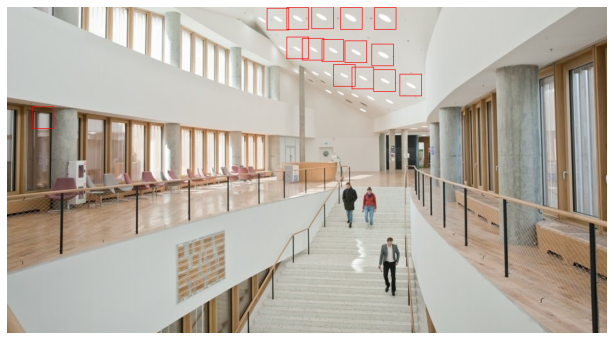

In [15]:
points = get_local_centers(corr_conv, 0.5)
res = plot_rectangles(img_orig, points, template.shape)

plot_img(res, cmap=None)

## Treshold playground

In [16]:
from ipywidgets import IntSlider, interact

In [17]:
sld = IntSlider(value=50, min=0, max=100, step=1, continuous_update=False)


def vary_corr_th(th):
    points = get_local_centers(corr_conv, th / 100)
    res = plot_rectangles(img_orig, points, template.shape)    
    plot_img(res, cmap=None)

In [18]:
interact(vary_corr_th, th=sld);

interactive(children=(IntSlider(value=50, continuous_update=False, description='th'), Output()), _dom_classes=…

## Scaling template & aggregating correlations

In [19]:
from skimage.transform import rescale

In [20]:
corr_conv_comb = [match_template(img, rescale(template, i / template.shape[0]), pad_input=True)
                  for i in range(template.shape[0] // 3, template.shape[0] + 1)]

In [21]:
corr_conv_mean = np.clip(np.sum([c > 0.67 for c in corr_conv_comb], axis=0), 0, 1)

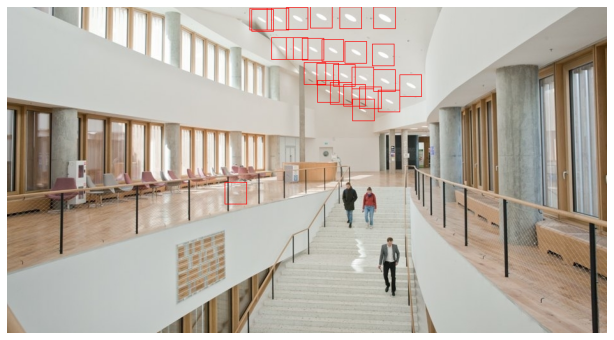

In [22]:
points = get_local_centers(corr_conv_mean, 0.5)
res = plot_rectangles(img_orig, points, template.shape)

plot_img(res, cmap=None)

## Pipeline playground

In [23]:
sld2 = IntSlider(value=67, min=0, max=100, step=1, continuous_update=False)


def vary_pipeline_th(th):
    corr_conv_mean = np.clip(np.sum([c > th / 100 for c in corr_conv_comb], axis=0), 0, 1)
    points = get_local_centers(corr_conv_mean, 0.5)
    res = plot_rectangles(img_orig, points, template.shape)    
    plot_img(res, cmap=None)

In [24]:
interact(vary_pipeline_th, th=sld2);

interactive(children=(IntSlider(value=67, continuous_update=False, description='th'), Output()), _dom_classes=…

## Different matching methods:

https://docs.opencv.org/3.4/de/da9/tutorial_template_matching.html

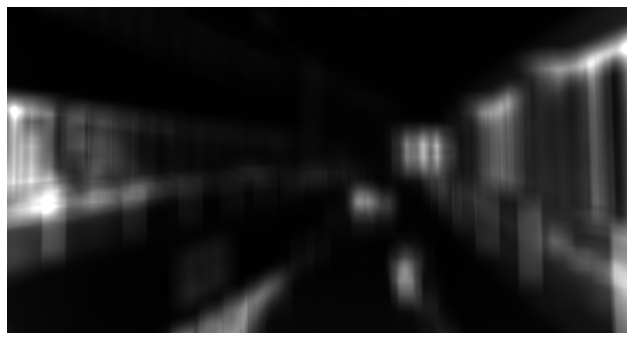

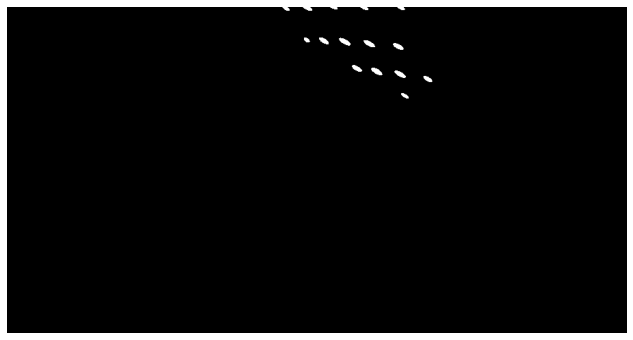

In [25]:
corr_cv2 = cv2.matchTemplate(img, template, method=cv2.TM_SQDIFF_NORMED)
plot_img(corr_cv2)
plot_img(corr_cv2 < 0.004)

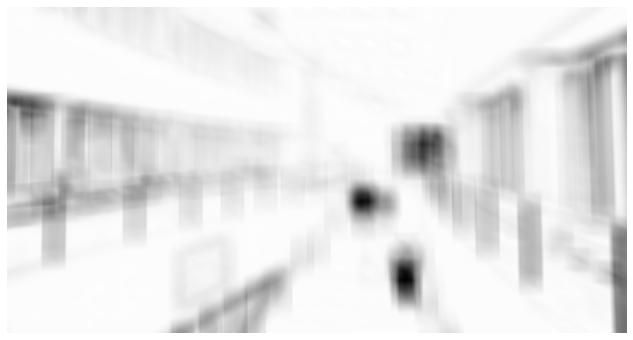

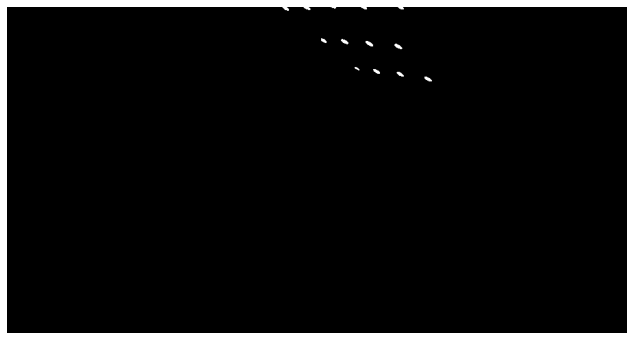

In [26]:
corr_cv2 = cv2.matchTemplate(img, template, method=cv2.TM_CCORR_NORMED)
plot_img(corr_cv2)
plot_img(corr_cv2 > 0.9985)